In [1]:
import os
import ROOT

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm

# Increase fontsize
plt.rcParams.update({'font.size': 22})

# Check if processed direcoty exists, if not create it
if not os.path.exists('processed'):
    os.makedirs('processed')

# Check if plot direcoty exists, if not create it
if not os.path.exists('plot'):
    os.makedirs('plot')

Welcome to JupyROOT 6.28/04


In [2]:
MevToKev = 1e3

def sigma( energy ):
    return np.sqrt( 216.6 + 843.8 * energy / MevToKev )

def sigma_quenching( energy ):
    return ( 0.2 * np.exp( energy / 812 ) + 85 )

def quenching( energy ):
    return ( 2.02e-4 * np.exp( energy / 840 ) + 3.090 ) * 1e3

def convert( h1, h2 ):

    events_gamma = []
    for i in range(h1.GetNbinsX()):
        content = h1.GetBinContent(i)
        energy = h1.GetBinCenter(i)
        for j in range(int(content)):
            events_gamma.append(energy)

    events_alpha = []
    for i in range(h2.GetNbinsX()):
        content = h2.GetBinContent(i)
        energy = h2.GetBinCenter(i)
        for j in range(int(content)):
            events_alpha.append(energy)

    events1 = [ ]
    events2 = [ ]
    for i in tqdm( range( len( events_gamma ) ) ):
        energy = events_gamma[i] * MevToKev
        events1.append( np.random.normal( energy, sigma( energy ) ) )

    for i in tqdm( range( len( events_alpha ) ) ):
        energy = events_alpha[i] * MevToKev
        energy_q = quenching( energy )
        events2.append( np.random.normal( energy_q, sigma_quenching( energy_q ) ) )

    df_gamma = pd.DataFrame( events1, columns = [ 'Energy' ] )
    df_gamma[ 'Type' ] = 'Gamma'

    df_alpha = pd.DataFrame( events2, columns = [ 'Energy' ] )
    df_alpha[ 'Type' ] = 'Alpha'

    return pd.concat( [ df_gamma, df_alpha ] )

In [3]:
f_40k = ROOT.TFile("output/40K.root")
h_40k_a = f_40k.Get("13")
h_40k_g = f_40k.Get("12")
df_40k = convert( h_40k_g, h_40k_a )
f_40k.Close( )
df_40k.to_pickle( "processed/40K.pkl" )

f_210pb = ROOT.TFile("output/210Pb.root")
h_210pb_a = f_210pb.Get("13")
h_210pb_g = f_210pb.Get("12")
df_210pb = convert( h_210pb_g, h_210pb_a )
f_210pb.Close( )
df_210pb.to_pickle( "processed/210Pb.pkl" )

f_228th = ROOT.TFile("data/sim/232Th.root")
h_228th_a = f_228th.Get("13")
h_228th_g = f_228th.Get("12")
df_228th = convert( h_228th_g, h_228th_a )
f_228th.Close( )
df_228th.to_pickle( "processed/228Th.pkl" )

f_238u = ROOT.TFile("output/238U.root")
h_238u_a = f_238u.Get("13")
h_238u_g = f_238u.Get("12")
df_238u = convert( h_238u_g, h_238u_a )

f_238u.Close( )
df_238u.to_pickle( "processed/238U.pkl" )

100%|██████████| 368515/368515 [00:00<00:00, 621325.48it/s]
0it [00:00, ?it/s]
/var/folders/13/_3g2lmwx6xl3zshjv1d7yz4c0000gn/T/ipykernel_41268/2103894461.py:45: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat( [ df_gamma, df_alpha ] )
100%|██████████| 8000320/8000320 [00:22<00:00, 352999.60it/s]


In [4]:
from scipy.optimize import minimize

# Load the observed data and simulation datasets
observed_data = pd.read_pickle( "data/NaI.pkl" )
simulation_data_40k = pd.read_pickle( "processed/40K.pkl" )
simulation_data_210pb = pd.read_pickle( "processed/210Pb.pkl" )
simulation_data_228th = pd.read_pickle( "processed/228Th.pkl" )
simulation_data_238u = pd.read_pickle( "processed/238U.pkl" )

# Mask alpha particles
simulation_data_40k_gamma = simulation_data_40k[simulation_data_40k["Type"] == "Gamma"]
simulation_data_210pb_gamma = simulation_data_210pb[simulation_data_210pb["Type"] == "Gamma"]
simulation_data_228th_gamma = simulation_data_228th[simulation_data_228th["Type"] == "Gamma"]
simulation_data_238u_gamma = simulation_data_238u[simulation_data_238u["Type"] == "Gamma"]

# Mask the alpha particles
simulation_data_40k_alpha = simulation_data_40k[simulation_data_40k["Type"] == "Alpha"]
simulation_data_210pb_alpha = simulation_data_210pb[simulation_data_210pb["Type"] == "Alpha"]
simulation_data_228th_alpha = simulation_data_228th[simulation_data_228th["Type"] == "Alpha"]
simulation_data_238u_alpha = simulation_data_238u[simulation_data_238u["Type"] == "Alpha"]

# Define the observed histogram
counts_observed, xbins = np.histogram(observed_data["Energy"] * 0.56, bins=1000, range=(0, 10000))

# Define counts for each data with histograms
counts_simulation_40k_gamma, _ = np.histogram(simulation_data_40k_gamma["Energy"], bins=1000, range=(0, 10000))
counts_simulation_210pb_gamma, _ = np.histogram(simulation_data_210pb_gamma["Energy"], bins=1000, range=(0, 10000))
counts_simulation_228th_gamma, _ = np.histogram(simulation_data_228th_gamma["Energy"], bins=1000, range=(0, 10000))
counts_simulation_238u_gamma, _ = np.histogram(simulation_data_238u_gamma["Energy"], bins=1000, range=(0, 10000))

# Define counts for each data with histograms
counts_simulation_40k_alpha, _ = np.histogram(simulation_data_40k_alpha["Energy"], bins=1000, range=(0, 10000))
counts_simulation_210pb_alpha, _ = np.histogram(simulation_data_210pb_alpha["Energy"], bins=1000, range=(0, 10000))
counts_simulation_228th_alpha, _ = np.histogram(simulation_data_228th_alpha["Energy"], bins=1000, range=(0, 10000))
counts_simulation_238u_alpha, _ = np.histogram(simulation_data_238u_alpha["Energy"], bins=1000, range=(0, 10000))

# Add it to the dataframes
observed_data = pd.DataFrame({"Bins": xbins[:-1], "Counts": counts_observed})
simulation_data_40k_gamma = pd.DataFrame({"Bins": xbins[:-1], "Counts": counts_simulation_40k_gamma})
simulation_data_210pb_gamma = pd.DataFrame({"Bins": xbins[:-1], "Counts": counts_simulation_210pb_gamma})
simulation_data_228th_gamma = pd.DataFrame({"Bins": xbins[:-1], "Counts": counts_simulation_228th_gamma})
simulation_data_238u_gamma = pd.DataFrame({"Bins": xbins[:-1], "Counts": counts_simulation_238u_gamma})
simulation_data_40k_alpha = pd.DataFrame({"Bins": xbins[:-1], "Counts": counts_simulation_40k_alpha})
simulation_data_210pb_alpha = pd.DataFrame({"Bins": xbins[:-1], "Counts": counts_simulation_210pb_alpha})
simulation_data_228th_alpha = pd.DataFrame({"Bins": xbins[:-1], "Counts": counts_simulation_228th_alpha})
simulation_data_238u_alpha = pd.DataFrame({"Bins": xbins[:-1], "Counts": counts_simulation_238u_alpha})

# Save the spectra to CSV
#observed_data.to_csv( "gianluca/observed.csv" )
#simulation_data_40k_gamma.to_csv( "gianluca/40K_gamma.csv" )
#simulation_data_210pb_gamma.to_csv( "gianluca/210Pb_gamma.csv" )
#simulation_data_228th_gamma.to_csv( "gianluca/228Th_gamma.csv" )
#simulation_data_238u_gamma.to_csv( "gianluca/238U_gamma.csv" )
#simulation_data_40k_alpha.to_csv( "gianluca/40K_alpha.csv" )
#simulation_data_210pb_alpha.to_csv( "gianluca/210Pb_alpha.csv" )
#simulation_data_228th_alpha.to_csv( "gianluca/228Th_alpha.csv" )
#simulation_data_238u_alpha.to_csv( "gianluca/238U_alpha.csv" )

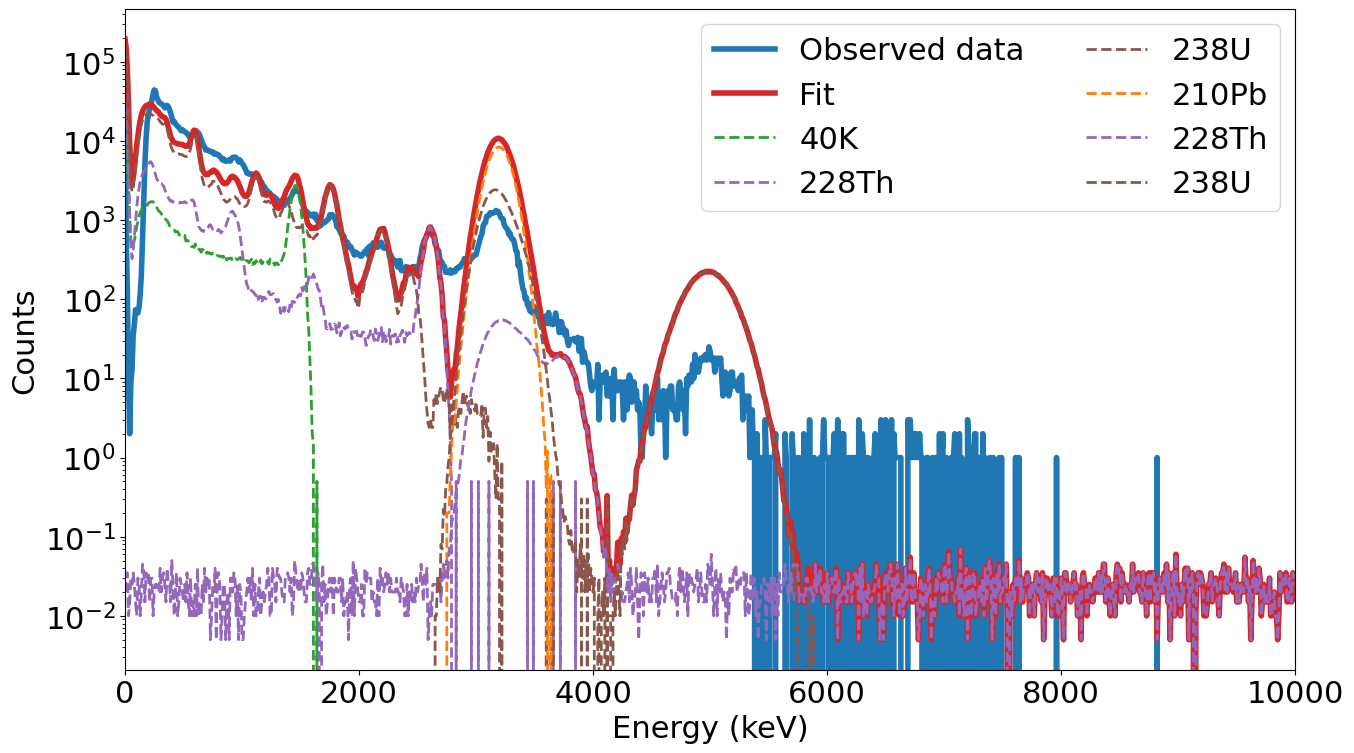

In [34]:
def model(params):
    # Calculate the expected counts for the gamma
    expected_counts_gamma = params[0] * simulation_data_40k_gamma["Counts"] + params[1] * simulation_data_228th_gamma["Counts"] + params[2] * simulation_data_238u_gamma["Counts"]
    # Calculculate the expected counts for alpha particles
    expected_counts_alpha = params[3] * simulation_data_210pb_alpha["Counts"] + params[4] * simulation_data_228th_alpha["Counts"] + params[5] * simulation_data_238u_alpha["Counts"]
    return expected_counts_gamma + expected_counts_alpha

def func(params, *args):
    # Calculate the expected counts
    expected_counts = model(params)
    # Mask points where the observed counts are zero
    mask = (observed_data["Counts"] > 0) & (observed_data["Bins"] > 1000)
    # Calculate the chi2
    chi2 = np.sum((observed_data["Counts"][mask] - expected_counts[mask]) ** 2 / observed_data["Counts"][mask])
    return chi2

# Initial guess
initial_guess = [0.05, 0.05, 0.03, 0.02, 0.0005, 0.001]
initial_guess = 10 * np.array(initial_guess)

# Set figure size
plt.figure(figsize=(14, 8))

# Plot the observed and expected data
plt.plot(observed_data["Bins"], observed_data["Counts"], label="Observed data", color="tab:blue", lw=4)
plt.plot(observed_data["Bins"], model( initial_guess ),  label="Fit",           color="tab:red",  lw=4)

plt.plot(simulation_data_40k_gamma["Bins"],   initial_guess[0] * simulation_data_40k_gamma["Counts"],     label="40K",   color="tab:green",  ls='--', lw=2)
#plt.plot(simulation_data_210pb_gamma["Bins"], initial_guess[1] * simulation_data_210pb_gamma["Counts"],   label="210Pb", color="tab:orange", ls='--', lw=2)
plt.plot(simulation_data_228th_gamma["Bins"], initial_guess[1] * simulation_data_228th_gamma["Counts"],   label="228Th", color="tab:purple", ls='--', lw=2)
plt.plot(simulation_data_238u_gamma["Bins"],   initial_guess[2] * simulation_data_238u_gamma["Counts"],     label="238U",   color="tab:brown",  ls='--', lw=2)

#plt.plot(simulation_data_40k_alpha["Bins"],   initial_guess[4] * simulation_data_40k_alpha["Counts"],     label="40K",   color="tab:green",  ls='--', lw=2)
plt.plot(simulation_data_210pb_alpha["Bins"], initial_guess[3] * simulation_data_210pb_alpha["Counts"],   label="210Pb", color="tab:orange", ls='--', lw=2)
plt.plot(simulation_data_228th_alpha["Bins"], initial_guess[4] * simulation_data_228th_alpha["Counts"],   label="228Th", color="tab:purple", ls='--', lw=2)
plt.plot(simulation_data_238u_alpha["Bins"],   initial_guess[5] * simulation_data_238u_alpha["Counts"],     label="238U",   color="tab:brown",  ls='--', lw=2)

plt.xlabel("Energy (keV)")
plt.ylabel("Counts")

plt.xlim(0, 10000)

plt.yscale("log")

# Legend with 2 columns
plt.legend(ncol=2)
plt.tight_layout()

plt.savefig("plot/initial.png")
plt.show()

In [35]:
# Put all parameters higher than 0
bounds = [(0, None)] * len(initial_guess)


# Minimize the chi2
result = minimize(func, initial_guess, bounds=bounds, args=(observed_data, simulation_data_40k, simulation_data_210pb, simulation_data_228th, simulation_data_238u))

# Print the result
print(result)

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 39270.84552465258
        x: [ 3.697e-01  6.397e-01  2.427e-01  2.143e-02  1.103e-02
             9.495e-04]
      nit: 29
      jac: [-1.397e-01  1.593e-01  3.449e-01  1.036e+00  2.666e+00
            -1.858e+01]
     nfev: 245
     njev: 35
 hess_inv: <6x6 LbfgsInvHessProduct with dtype=float64>


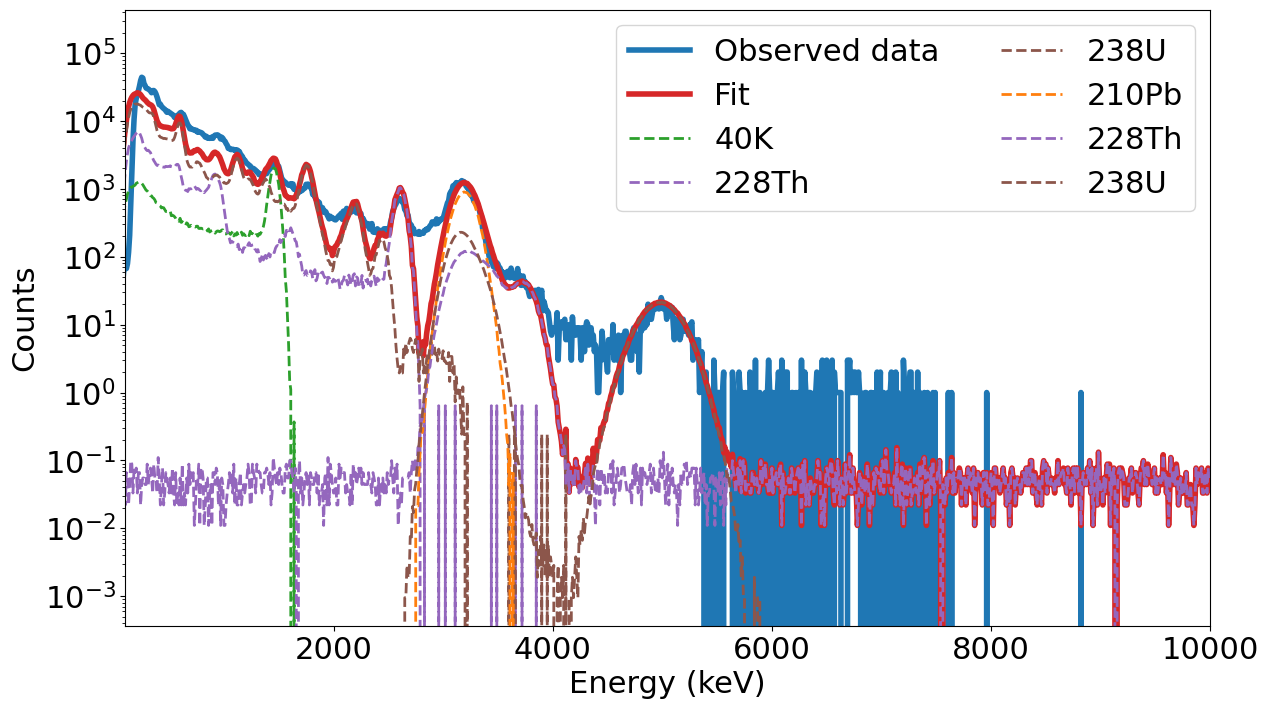

In [38]:
# Set figure size
plt.figure(figsize=(14, 8))

# Plot the observed and expected data
plt.plot(observed_data["Bins"], observed_data["Counts"], label="Observed data", color="tab:blue", lw=4)
plt.plot(observed_data["Bins"], model(result.x), label="Fit", color="tab:red", lw=4)

plt.plot(simulation_data_40k_gamma["Bins"], result.x[0] * simulation_data_40k_gamma["Counts"], label="40K", color="tab:green", ls='--', lw=2)
#plt.plot(simulation_data_210pb_gamma["Bins"], result.x[1] * simulation_data_210pb_gamma["Counts"], label="210Pb", color="tab:orange", ls='--', lw=2)
plt.plot(simulation_data_228th_gamma["Bins"], result.x[1] * simulation_data_228th_gamma["Counts"], label="228Th", color="tab:purple", ls='--', lw=2)
plt.plot(simulation_data_238u_gamma["Bins"], result.x[2] * simulation_data_238u_gamma["Counts"], label="238U", color="tab:brown", ls='--', lw=2)

#plt.plot(simulation_data_40k_alpha["Bins"], result.x[4] * simulation_data_40k_alpha["Counts"], label="40K", color="tab:green", ls='--', lw=2)
plt.plot(simulation_data_210pb_alpha["Bins"], result.x[3] * simulation_data_210pb_alpha["Counts"], label="210Pb", color="tab:orange", ls='--', lw=2)
plt.plot(simulation_data_228th_alpha["Bins"], result.x[4] * simulation_data_228th_alpha["Counts"], label="228Th", color="tab:purple", ls='--', lw=2)
plt.plot(simulation_data_238u_alpha["Bins"], result.x[5] * simulation_data_238u_alpha["Counts"], label="238U", color="tab:brown", ls='--', lw=2)

plt.xlabel("Energy (keV)")
plt.ylabel("Counts")

plt.yscale("log")

plt.xlim(100, 10000)

#plt.xlim(500, 2000)
#plt.ylim(5e2, 3e4)

plt.legend( ncol=2 )

plt.savefig("plot/fit.png")
plt.show()

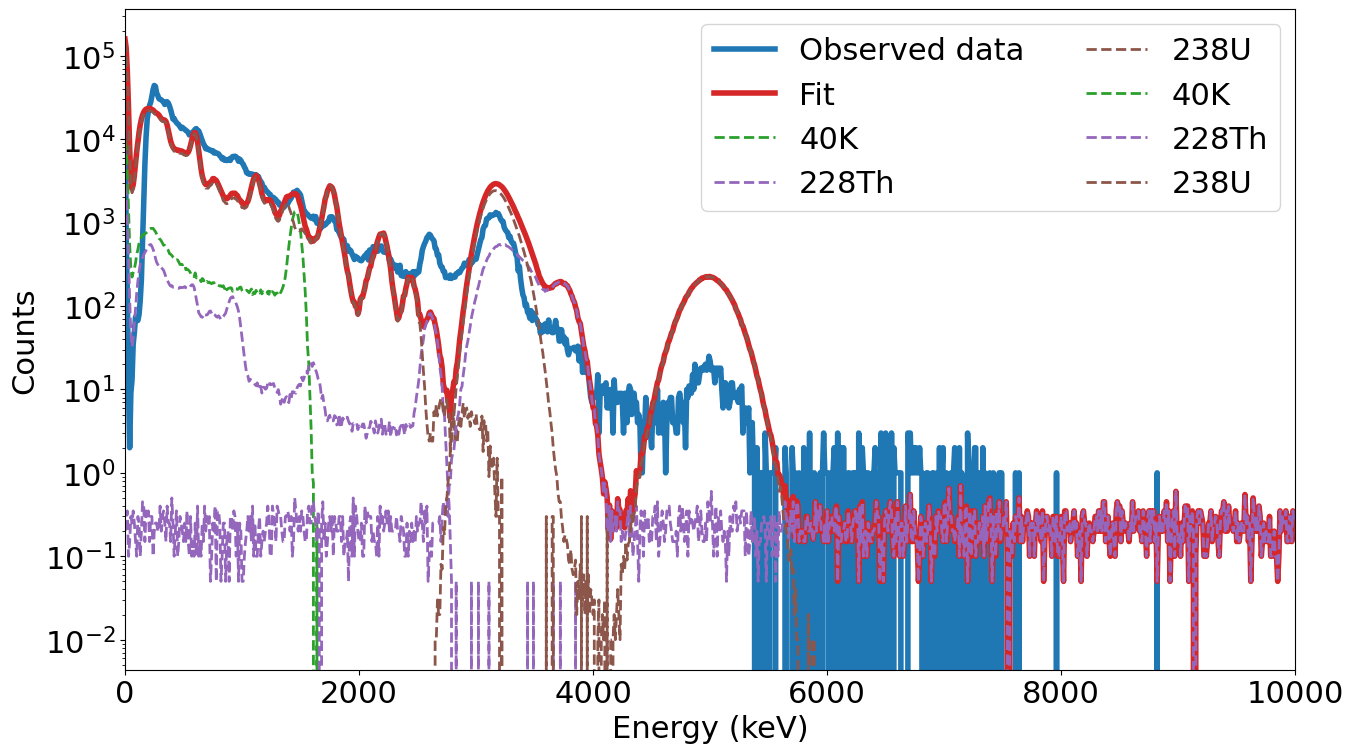

In [30]:
def model(params):
    # Calculate the expected counts for the gamma
    expected_counts_gamma = params[0] * simulation_data_40k_gamma["Counts"] + params[1] * simulation_data_228th_gamma["Counts"] + params[2] * simulation_data_238u_gamma["Counts"]
    # Calculculate the expected counts for alpha particles
    expected_counts_alpha = params[3] * simulation_data_40k_alpha["Counts"] + params[4] * simulation_data_228th_alpha["Counts"] + params[5] * simulation_data_238u_alpha["Counts"]
    return expected_counts_gamma + expected_counts_alpha

def func(params, *args):
    # Calculate the expected counts
    expected_counts = model(params)
    # Mask points where the observed counts are zero
    mask = (observed_data["Counts"] > 0) & (observed_data["Bins"] > 1000)
    # Calculate the chi2
    chi2 = np.sum((observed_data["Counts"][mask] - expected_counts[mask]) ** 2 / observed_data["Counts"][mask])
    return chi2

# Initial guess
initial_guess = [0.25, 0.05, 0.3, 0.25, 0.05, 0.01]

# Set figure size
plt.figure(figsize=(14, 8))

# Plot the observed and expected data
plt.plot(observed_data["Bins"], observed_data["Counts"], label="Observed data", color="tab:blue", lw=4)
plt.plot(observed_data["Bins"], model( initial_guess ),  label="Fit",           color="tab:red",  lw=4)

plt.plot(simulation_data_40k_gamma["Bins"],   initial_guess[0] * simulation_data_40k_gamma["Counts"],     label="40K",   color="tab:green",  ls='--', lw=2)
plt.plot(simulation_data_228th_gamma["Bins"], initial_guess[1] * simulation_data_228th_gamma["Counts"],   label="228Th", color="tab:purple", ls='--', lw=2)
plt.plot(simulation_data_238u_gamma["Bins"],   initial_guess[2] * simulation_data_238u_gamma["Counts"],     label="238U",   color="tab:brown",  ls='--', lw=2)

plt.plot(simulation_data_40k_alpha["Bins"],   initial_guess[3] * simulation_data_40k_alpha["Counts"],     label="40K",   color="tab:green",  ls='--', lw=2)
plt.plot(simulation_data_228th_alpha["Bins"], initial_guess[4] * simulation_data_228th_alpha["Counts"],   label="228Th", color="tab:purple", ls='--', lw=2)
plt.plot(simulation_data_238u_alpha["Bins"],   initial_guess[5] * simulation_data_238u_alpha["Counts"],     label="238U",   color="tab:brown",  ls='--', lw=2)

plt.xlabel("Energy (keV)")
plt.ylabel("Counts")

plt.yscale("log")

plt.xlim(0, 10000)

# Legend with 2 columns
plt.legend(ncol=2)
plt.tight_layout()

# Increase fontsize
plt.rcParams.update({'font.size': 22})

plt.show()

In [31]:
# Put all parameters higher than 0
bounds = [(0, None)] * len(initial_guess)

# Minimize the chi2
result = minimize(func, initial_guess, bounds=bounds, args=(observed_data, simulation_data_40k, simulation_data_210pb, simulation_data_228th, simulation_data_238u))

# Print the result
print(result)

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 1508681.702320979
        x: [ 0.000e+00  2.825e-02  0.000e+00  2.500e-01  1.856e-02
             2.247e-03]
      nit: 19
      jac: [ 1.496e+05  4.657e-02  5.701e+05  0.000e+00 -4.657e-02
             2.794e-01]
     nfev: 175
     njev: 25
 hess_inv: <6x6 LbfgsInvHessProduct with dtype=float64>


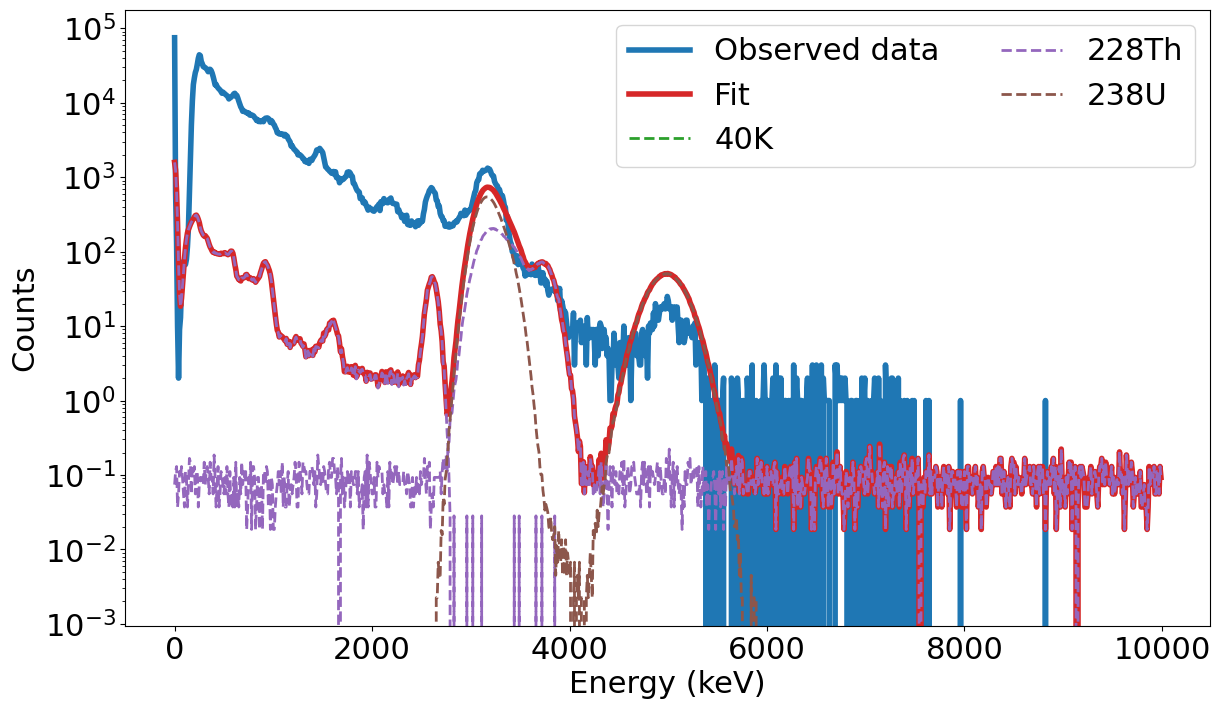

In [32]:
# Plot
plt.figure(figsize=(14, 8))

#result.x[4] = 2 * result.x[4]

# Plot the observed and expected data
plt.plot(observed_data["Bins"], observed_data["Counts"], label="Observed data", color="tab:blue", lw=4)
plt.plot(observed_data["Bins"], model(result.x), label="Fit", color="tab:red", lw=4)

plt.plot(simulation_data_40k_gamma["Bins"], result.x[0] * simulation_data_40k_gamma["Counts"], label="40K", color="tab:green", ls='--', lw=2)
plt.plot(simulation_data_228th_gamma["Bins"], result.x[1] * simulation_data_228th_gamma["Counts"], label="228Th", color="tab:purple", ls='--', lw=2)
plt.plot(simulation_data_238u_gamma["Bins"], result.x[2] * simulation_data_238u_gamma["Counts"], label="238U", color="tab:brown", ls='--', lw=2)

plt.plot(simulation_data_40k_alpha["Bins"], result.x[3] * simulation_data_40k_alpha["Counts"], color="tab:green", ls='--', lw=2)
plt.plot(simulation_data_228th_alpha["Bins"], result.x[4] * simulation_data_228th_alpha["Counts"], color="tab:purple", ls='--', lw=2)
plt.plot(simulation_data_238u_alpha["Bins"], result.x[5] * simulation_data_238u_alpha["Counts"], color="tab:brown", ls='--', lw=2)

plt.xlabel("Energy (keV)")
plt.ylabel("Counts")

plt.yscale("log")

plt.legend(ncol=2)

plt.savefig( "plot/fit_no_210Pb.png" )
plt.show()